# Using Quantum Computer as a sound effect processor

## https://arxiv.org/abs/2301.01595

When producing music, there are different effects that you can do in order to make interesting effects. This codebook will present how to encode audio in pennylane and how to make your own interesting effects!
We'll see how to make a quantum distortion effect.

In [19]:
from IPython.display import Audio
display(Audio("Megalovania Meme Sound Effect.wav"))
display(Audio("demo_qhack_1.wav"))
display(Audio("qhack_demo2.wav"))
display(Audio("qhack_demo3.wav"))
display(Audio("qhack_demo4.wav"))

In [151]:
# utility cell
import pennylane as qml
import pennylane.numpy as np
import scipy.io.wavfile
import wave
import time
import math
import matplotlib.pyplot as plt
import copy

# Function to load a WAV file
def load_wav(filename):
    sample_rate, data = scipy.io.wavfile.read(filename)
    # If stereo, convert to mono by averaging the two channels
    if len(data.shape) == 2:
        data = data.mean(axis=1)
    return sample_rate, data

# Function to save a WAV file
def save_wav(filename, sample_rate, data):
    scipy.io.wavfile.write(filename, sample_rate, data)

In [22]:
filename = 'qhack_demo4.wav'  # audio file to encode into the quantum computer

The way QPAM encoding works is by...

In [175]:
sample_rate, original_data = load_wav(filename)

def QPAM_Encoding_Normalization(samples):
    # Normalize the array to be between 0 and 2
    normalized_arr = 2 * (samples - np.min(samples)) / (np.max(samples) - np.min(samples))

    # 2301.01595.pdf
    # • Step 1: add 1 to all amplitudes an
    # • Step 2: divide the amplitudes by 2
    # • Step 3: divide again, by the sum of all of the amplitudes
    # • Step 4: take the square root of the result

    np_data = np.array(normalized_arr)
    np_data += 1
    np_data /= 2
    sum = np.sum(np_data)
    np_data = np_data/sum

    print(np_data)
    return np_data

features = QPAM_Encoding_Normalization(original_data)
length = features.shape[0]
nb_qubits = math.ceil(np.log2(length))

[1.13398837e-05 1.13399430e-05 1.13408798e-05 ... 1.31006615e-05
 1.08222664e-05 8.02100313e-06]


C:\Users\Kuift\AppData\Local\Temp\ipykernel_19312\3098465682.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = scipy.io.wavfile.read(filename)


In [187]:
dev = qml.device('default.qubit', wires=nb_qubits)
nb_qubits

17

In [188]:
@qml.qnode(dev)
def circuit(f=None):
    qml.AmplitudeEmbedding(features=f, wires=range(nb_qubits), pad_with=0,normalize=True)
    return qml.probs(wires=range(nb_qubits))
results = circuit(features)
print(f"encoding result: {results}")


encoding result: [1.08557612e-05 1.08558747e-05 1.08576685e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [189]:
# Create a WAV file
normalized_results = ((results - np.min(results)) / (np.max(results) - np.min(results))) * (32767 + 32768) - 32768
newwave_name = f'qhack_demo_{time.time()}.wav'
quantum_samples_array = []
with wave.open(newwave_name, 'w') as wav_file:
    # Set the parameters: 1 channel, 2 bytes per sample, sample rate, number of frames, compression type, compression name
    wav_file.setparams((1, 2, sample_rate, length, 'NONE', 'not compressed'))
    
    # Write the samples to the file
    quantum_samples_array = np.array(normalized_results, dtype=np.int16)
    print(quantum_samples_array)
    wav_file.writeframes(np.array(quantum_samples_array).tobytes())

print(f"{newwave_name} file has been created.")
orig_result = copy.deepcopy(normalized_results)
copy_result = copy.deepcopy(normalized_results)
display(Audio(newwave_name))

[ -4965  -4965  -4961 ... -32768 -32768 -32768]
qhack_demo_1707500860.5667627.wav file has been created.


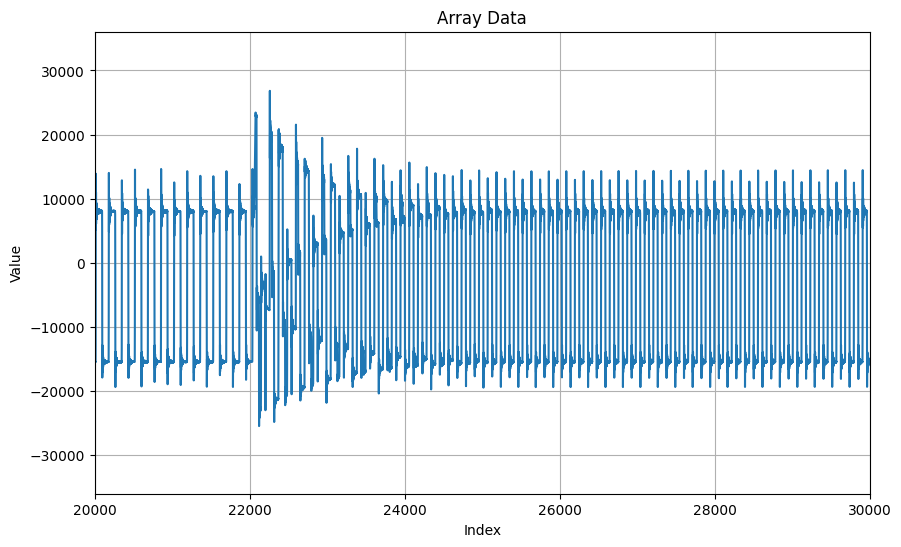

In [190]:
#graphing
plt.figure(figsize=(10, 6))
plt.plot(orig_result)
plt.xlim(20000, 30000)
plt.title("Array Data")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()

Lets see what happen if you "deepfry" it. That is, lets test the audio degradation after going through the quantum audio encoding and decoding process a couple of time to hear the fidelity

In [195]:
copy_result = copy.deepcopy(orig_result) 
deepfry_quantum_samples_array = copy.deepcopy(quantum_samples_array)
for i in range(2): #CHANGE THE VALUE INSIDE THE RANGE HERE TO DEEPFRY IT EVEN DEEPER
    deepfry_result = circuit(QPAM_Encoding_Normalization(deepfry_quantum_samples_array))
    # Create a WAV file
    copy_result = ((deepfry_result - np.min(deepfry_result)) / (np.max(deepfry_result) - np.min(deepfry_result))) * (32767 + 32768) - 32768
    deepfry_quantum_samples_array = np.array(copy_result, dtype=np.int16)

newwave_name = f'qhack_demo_{time.time()}.wav'
with wave.open(newwave_name, 'w') as wav_file:
    # Set the parameters: 1 channel, 2 bytes per sample, sample rate, number of frames, compression type, compression name
    wav_file.setparams((1, 2, sample_rate, length, 'NONE', 'not compressed'))
    
    # Write the samples to the file
    deepfry_quantum_samples_array = np.array(copy_result, dtype=np.int16)
    print(deepfry_quantum_samples_array)
    wav_file.writeframes(np.array(deepfry_quantum_samples_array).tobytes())

display(Audio(newwave_name))

[6.84274073e-06 6.84274073e-06 6.84372521e-06 ... 8.06472464e-06
 8.06472464e-06 8.06472464e-06]
[1.10847992e-05 1.10847992e-05 1.10864102e-05 ... 5.65603114e-06
 5.65603114e-06 5.65603114e-06]
[ 29858  29858  29879 ... -22524 -22524 -22524]


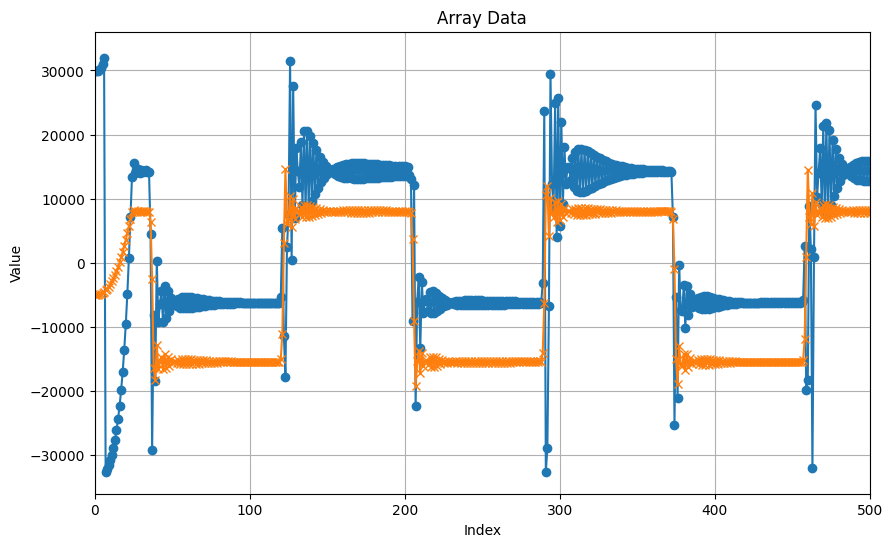

In [197]:
#graphing
plt.figure(figsize=(10, 6))
plt.plot(copy_result, marker='o')
plt.plot(orig_result, marker='x', label='Original Results')
plt.xlim(0, 500)
plt.title("Array Data")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()